# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [2]:
# Initial import
import dcgpy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

### Data set

In [3]:
# We import the data for a classification task
from numpy import genfromtxt
# https://archive.ics.uci.edu/ml/datasets/Abalone
my_data = genfromtxt('abalone_data_set.csv', delimiter=',')
points = my_data[:,:-1]
labels_tmp = my_data[:,-1]
# We trasform the categorical variables to one hot encoding
labels = np.zeros((len(labels_tmp), 29))
for i,l in enumerate(labels_tmp):
    labels[i][int(l)-1] = 1
    

### Mutating a dCGPANN

In [4]:
# Non linearities
nonlinearities = dcgpy.kernel_set_double(["sig", "ReLu", "tanh"])
# We define a single input single output dCGPANN.
dcgpann = dcgpy.expression_ann_double(inputs=8, outputs=29, rows=30, cols=5, 
                                      levels_back=2, arity=30, kernels=nonlinearities())
# By default all weights (and biases) are set to 1 (and 0). We initialize them randomly
dcgpann.randomise_weights(mean = 0., std = 0.1)
#dcgpann.randomise_biases(mean = 0., std = 0.001)

# Since the output is in [-1, 1] we force the output nonliearity to be tanh
dcgpann.set_output_f(2)

print("Starting error:", dcgpann.loss(points,labels, "CE"))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))
x = dcgpann.get()
w = dcgpann.get_weights()
b = dcgpann.get_biases()


Starting error: 3.368374446075054
Net complexity (number of active nodes): 140


100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


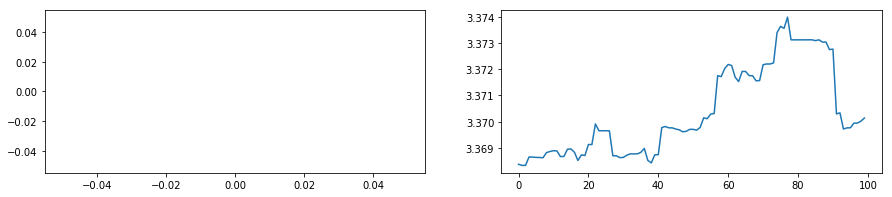

In [19]:
# We show the effect of mutations
n_mutations = 100
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(x)
    dcgpann.set_weights(w)
    dcgpann.set_biases(b)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(2)
    mut.append(dcgpann.loss(points,labels, "CE"))
    
mut2 = []
dcgpann.set(x)
dcgpann.set_weights(w)
dcgpann.set_biases(b)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(1)
    dcgpann.set_output_f(2)
    mut2.append(dcgpann.loss(points,labels, "CE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


In [15]:
dcgpann.set(x)
dcgpann.set_weights(w)
dcgpann.set_biases(b)
# We train
n_epochs = 10
print("Start error:", dcgpann.loss(points,labels, "CE"), flush=True)

for i in tqdm(range(n_epochs)):
    dcgpann.sgd(points, labels, 0.1, 32, "CE")

print("Current error:", dcgpann.loss(points,labels, "CE"), flush=True)

xt = dcgpann.get()
wt = dcgpann.get_weights()
bt = dcgpann.get_biases()



Start error: 3.368374446075054


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]

Current error: 2.7116786221919353


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


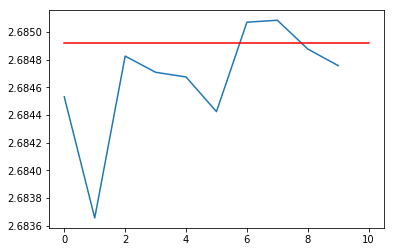

In [16]:
# We show the effect of trained mutations
n_mutations = 10
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(2)
    for i in range(n_epochs):
        dcgpann.sgd(points, labels, 0.1, 32, "CE")
    mut.append(dcgpann.loss(points,labels, "CE"))

dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in range(n_epochs):
    dcgpann.sgd(points, labels, 0.1, 32, "CE")

_ = plt.plot(mut)
_ = plt.plot([0,n_mutations],[dcgpann.loss(points,labels, "CE"),dcgpann.loss(points,labels, "CE")],'r')